In [2]:
%matplotlib inline

In [152]:
import sys
sys.path.append('../src/')

import glob
import warnings

import numpy as np
import pandas as pd
import xarray as xr

from scipy.optimize import curve_fit, minimize
from scipy import integrate,interpolate
from scipy.linalg import lstsq

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray
import gsw

from sklearn.linear_model import LinearRegression

from epsilon_tools import *
# from tools import str2date, avg_funs

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='notebook', palette='colorblind')
mpl.rc('figure', dpi=100, figsize=[12, 4])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

In [5]:
file = '../data/goship/selected/P01_20070724_00011_00001_ct1.csv'
data = pd.read_csv(file,header=17,skipfooter=1,engine='python')
# data = data.drop(columns=['Unnamed: 1','Unnamed: 3','Unnamed: 5','Unnamed: 7','Unnamed: 8','ML/L'])
data = data.drop(columns=['Unnamed: 1','Unnamed: 3','Unnamed: 5','Unnamed: 7','Unnamed: 9','Unnamed: 10','MG/M^3','UMOL/KG'])
data.rename(columns={'ITS-90':'tmp','PSS-78':'sal','DBAR':'prs'},inplace=True)

In [954]:
lon0 = 146.3
lat0 = 41.9
data['sal'] = gsw.SA_from_SP(data.sal,data.prs,lon0,lat0)
data['tmp'] = gsw.CT_from_t(data.sal,data.tmp,data.prs)
data['rho'] = gsw.rho(data.sal,data.tmp,0)
data['z'] = gsw.z_from_p(data.prs, lat0)

In [955]:
bins = np.arange(0,6000,2)
data = data.groupby(pd.cut(data.prs,bins)).mean()

In [956]:
ds = pd.DataFrame()
ds['N2'],ds['pmid']= gsw.Nsquared(data.sal,data.tmp,data.prs,lat=40)
ds['z'] = gsw.z_from_p(ds.pmid, lat0)

In [957]:
ds = ds.rolling(window=10,center=True,win_type='hamming').mean()
N0 = np.nanmean( np.sqrt(ds.N2) )
ds['N/N0'] = np.sqrt(ds.N2)/N0

### GO-SHIP full-depth T,S,$\rho$ profiles

In [985]:
stitch_rho = np.hstack( [raw.rho0.mean('time').values, data.rho[zvalues<-400] ])
stitch_z = np.hstack( [raw.rho0.mean('time').z.values, data.z[zvalues<-400] ])

In [986]:
stitch = pd.DataFrame()

In [987]:
stitch['rho'] = stitch_rho
stitch['z'] = stitch_z

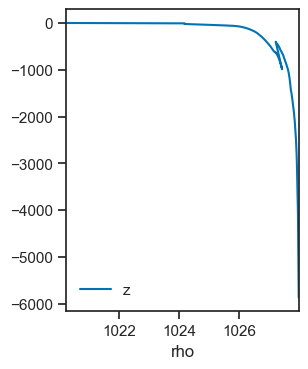

In [988]:
stitch.plot(y='z',x='rho',figsize=(3,4))

Text(0.5, 0, 'N/N0')

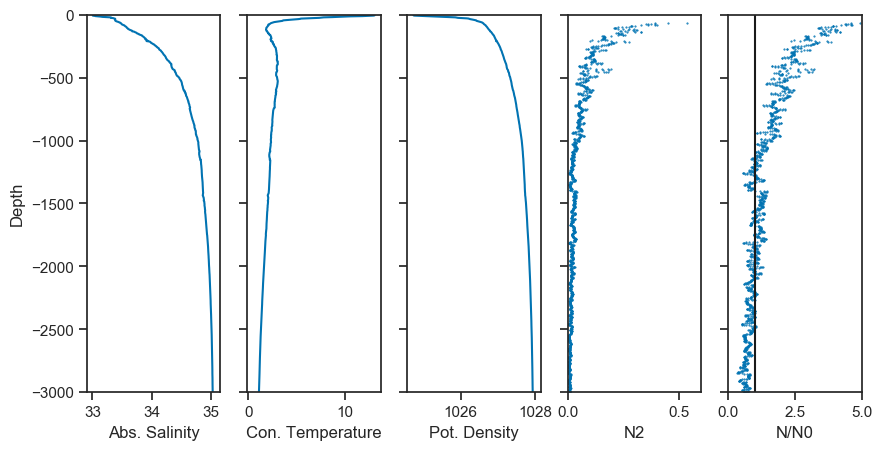

In [964]:
f,ax = plt.subplots(1,5,sharey=True, figsize=(10,5))
ax[0].plot(data.sal,data.z,'-')
ax[0].set_ylabel('Depth')
ax[0].set_xlabel('Abs. Salinity')
ax[1].plot(data.tmp,data.z,'-')
ax[1].set_xlabel('Con. Temperature')
ax[2].plot(data.rho,data.z,'-')
ax[2].set_xlabel('Pot. Density')

ax[3].plot(ds.N2*1e4,ds.z,'.', markersize=1)
# ax[3].axvline(N0,color='k')
# ax[3].set_xscale('log')
# ax[3].set_xlim(5e-4,1e-2);
ax[3].set_xlabel('N2')
ax[3].set_xlim(0,0.6)
ax[3].set_ylim(-3000,0)

ax[4].plot(ds['N/N0'],ds.z,'.', markersize=1)
ax[4].axvline(N0/N0,color='k')
# ax[4].set_xscale('log')
ax[4].set_xlim(0,5);
ax[4].set_xlabel('N/N0')

# plt.ylim(-1000,0)

### WKB-streched depth z':
$$
z'(z) = \int_0^z \frac{N(z)}{<N>} dz
$$

In [965]:
ds = ds.sort_values('z',ascending=False)
ds = ds.dropna()
zmid = 0.5*( ds.z.values[0:-1] + ds.z.values[1:])
zprime = integrate.cumtrapz(ds['N/N0'],ds['z'])

In [994]:
from scipy.interpolate import interp1d

In [996]:
F = interp1d(zmid,zprime)

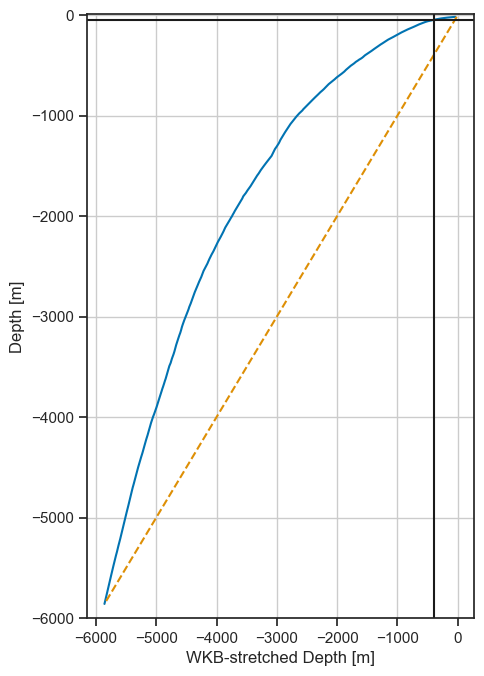

In [993]:
plt.figure(figsize=(5,8))
plt.plot(zprime,zmid)
plt.plot(zmid,zmid,linestyle='dashed')
plt.axhline(-47, color='k')
plt.axvline(-400, color='k')
# plt.annotate('max. z observation',(-6000,-400))
plt.ylabel('Depth [m]')
plt.xlabel("WKB-stretched Depth [m]")
plt.grid()
plt.ylim(-6000,10);

In [967]:
fraction_resolved = -100*1700/ds.z.min()
print(f'Fraction of the water column resolved: {fraction_resolved:2.2f}%')

Fraction of the water column resolved: 29.01%


### Vertical IW modes for N=const

Equation for vertical structure W from ansatz in wave equation:
$$
\frac{d^2W}{dz^2} + k^2 \left( \frac{N^2}{\omega^2} -1 \right)W = 0
$$
with
$$
W = 0 ~@~ z=-D,0
$$

In [968]:
D = -ds.z.min()
W = np.zeros((len(zprime),3))
for j in range(1,4):
    W[:,j-1] = np.sin(j*np.pi*zprime/D)

Text(0, 0.5, 'Depth')

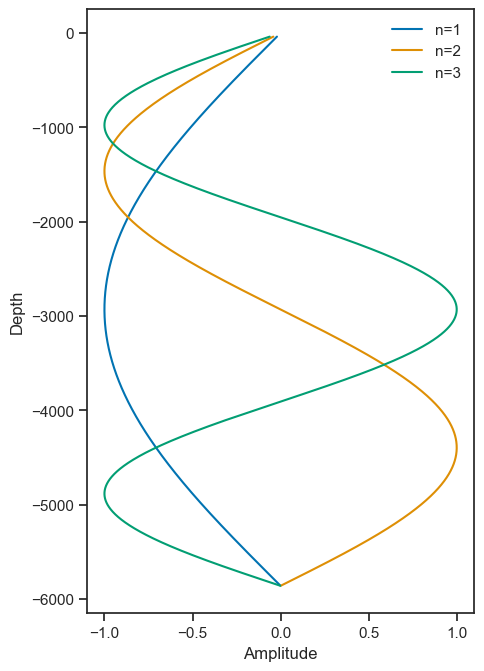

In [1722]:
plt.figure(figsize=(5,8))
for i in [0,1,2]:
    plt.plot(W[:,i],zprime)
plt.legend(labels=['n=1','n=2','n=3','n=4','n=5']);
# plt.fill_between([-1,1],y1=-500,y2=0,alpha=0.2, color='k');

plt.xlabel('Amplitude')
plt.ylabel('Depth')

# Fit vertical modes to velocity step function

In [1755]:
nmodes = 100
D = ds.z.min()
U = np.zeros((len(zprime),nmodes))
for j in range(1,nmodes+1):
    U[:,j-1] = -j*np.pi*np.cos(j*np.pi*zprime/D)/D # for vertical velocity 

Text(0.5, 0, 'Amplitude')

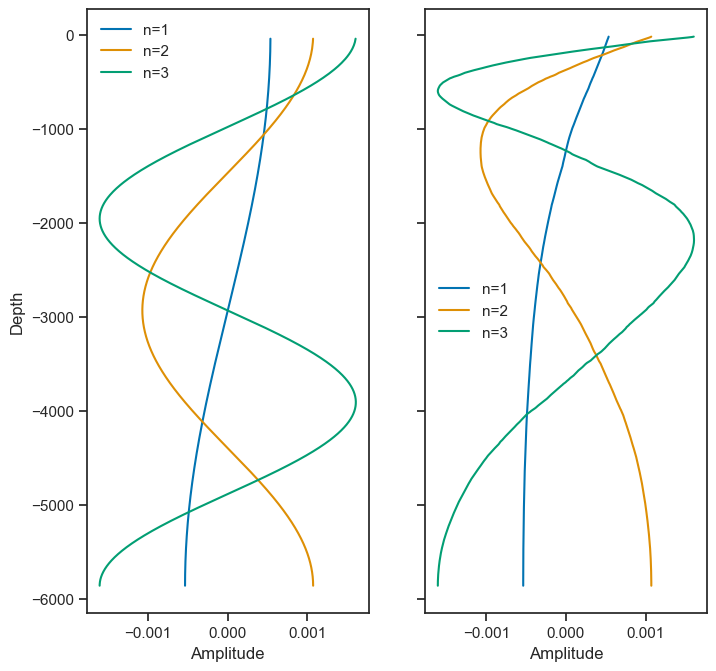

In [1756]:
fig, ax = plt.subplots(1,2,figsize=(8,8), sharey=True)
for i in [0,1,2]:
    ax[0].plot(U[:,i],zprime)
ax[0].legend(labels=['n=1','n=2','n=3','n=4','n=5']);
ax[0].set_xlabel('Amplitude')
ax[0].set_ylabel('Depth')

for i in [0,1,2]:
    ax[1].plot(U[:,i],zmid)
ax[1].legend(labels=['n=1','n=2','n=3','n=4','n=5']);

ax[1].set_xlabel('Amplitude')
# ax[1].set_ylabel('Depth')

In [1757]:
profile1 = raw.isel(time=180)
step = np.zeros_like(zprime)
step[zprime>F(profile1.mmld.values)] = profile1.surf
x,res,rank,s =  lstsq(U,step)

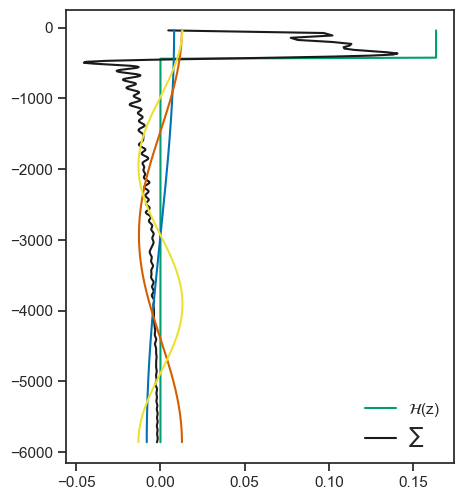

In [1758]:
plt.figure(figsize=(5,6))
plt.plot(step,zprime,color='g', label=r'$\mathcal{H}$(z)')
plt.plot(np.dot(U,x),zprime,color='k', label=r'$\sum$')

plt.plot(x[0]*U[:,0],zprime,color='b')
plt.plot(x[1]*U[:,1],zprime,color='r')
plt.plot(x[2]*U[:,2],zprime,color='y')
# plt.plot(x[3]*W[:,3],zprime,color='g')
# plt.plot(x[4]*W[:,4],zprime,color='g')

# plt.ylim(-1000,0)
plt.legend()

In [1759]:
raw = xr.open_dataset('../data/raw_temp.nc')

In [1760]:
raw['mmld'] = raw.mld.rolling(time=38, center=True).mean()

In [1761]:
raw['usurf'] = raw.u.where(raw.z>raw.mld).mean('z')
raw['vsurf'] = raw.v.where(raw.z>raw.mld).mean('z')
raw['surf'] = (0.5*raw.usurf**2 + 0.5*raw.vsurf**2).pipe(np.sqrt).interpolate_na('time').rolling(time=18, center=True).mean()

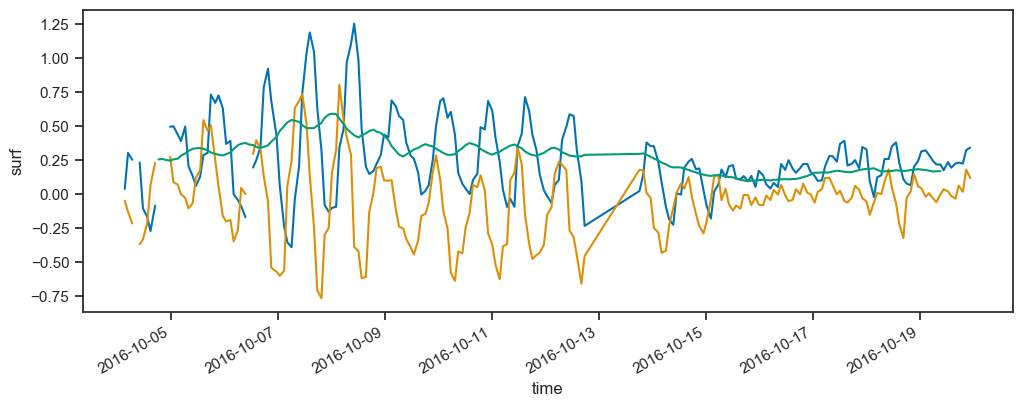

In [1762]:
raw.usurf.plot()
raw.vsurf.plot()
raw.surf.plot()

In [1763]:
liste= []
for ti, t in enumerate( raw.time ):
    profile1 = raw.isel(time=ti)
    step = np.zeros_like(zprime)
    if profile1.mld.values<-17:
        step[zprime>F(profile1.mmld.values)] = profile1.surf #/np.abs(profile1.surf)
        x,_,_,_ =  lstsq(U,step)
    else:
        x = np.ones(nmodes)*np.nan
    liste.append(x)

In [1764]:
amps_u = np.array( liste )
raw['amps_u'] = (('time','mode'),np.abs( amps_u))
# raw['amps_u'] = (('time','mode'),amps_u)

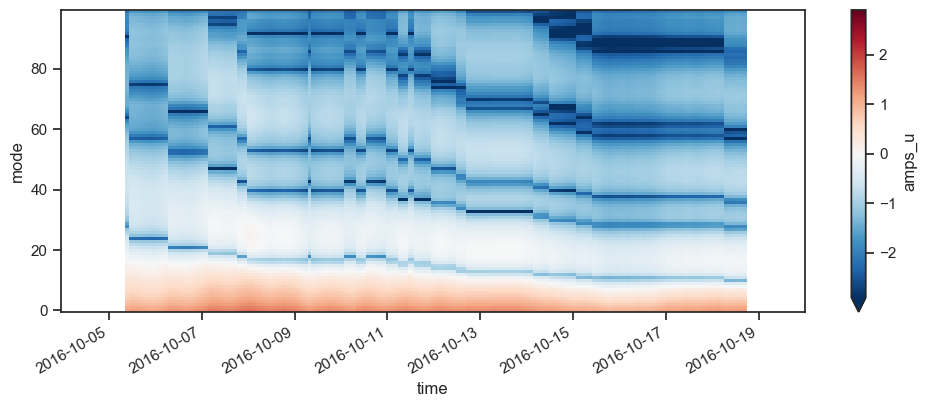

In [1774]:
raw.amps_u.transpose().pipe(np.log10).plot(cmap='RdBu_r', robust=True)

(0, 1)

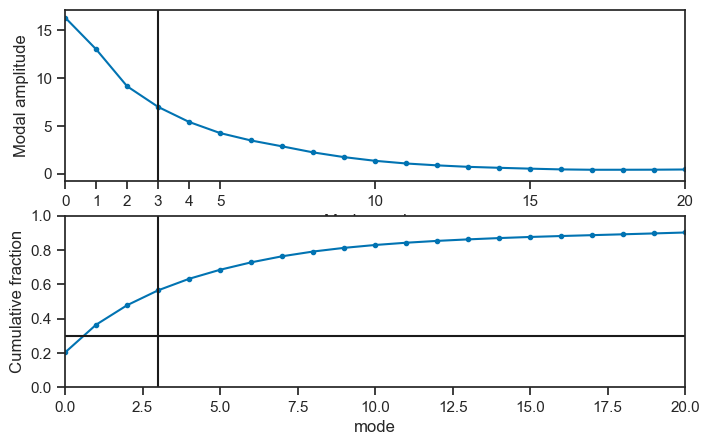

In [1768]:
fig, ax = plt.subplots(2,1,figsize=(8,5))
(raw.amps_u.mean('time')).plot(marker='.', ax=ax[0])
ax[0].set_xticks(np.hstack( [np.arange(0,5),np.arange(5,21,5)] ))
ax[0].set_xlim(0,50)
ax[0].set_ylabel('Modal amplitude')
ax[0].set_xlabel('Mode number')
ax[0].axvline(3, color='k')
ax[0].set_xlim(0,20)

raw.amps_u.cumsum('mode').mean('time').pipe(lambda x: x/80).plot(marker='.', ax=ax[1])
ax[1].axvline(3, color='k')
ax[1].axhline(0.3, color='k')
ax[1].set_ylabel('Cumulative fraction')
ax[1].set_xlim(0,20)
ax[1].set_ylim(0,1)

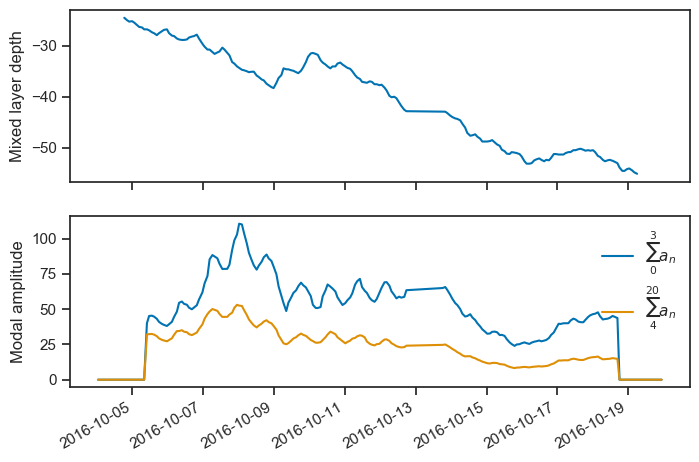

In [1775]:
fig,ax = plt.subplots(2,1, figsize=(8,5), sharex=True)

raw.mld.rolling(time=21, center=True).mean().plot(ax=ax[0])
ax[0].set_xlabel(None)
ax[0].set_ylabel('Mixed layer depth')

(raw.amps_u.isel(mode=slice(0,4)).sum('mode')).pipe(np.abs).plot(label=r'$\sum_0^3 a_n$', ax=ax[1])
(raw.amps_u.isel(mode=slice(5,20)).sum('mode')).pipe(np.abs).plot(label=r'$\sum_4^{20} a_n$', ax=ax[1])
plt.xlabel(None)
plt.ylabel('Modal amplitude')
plt.legend()

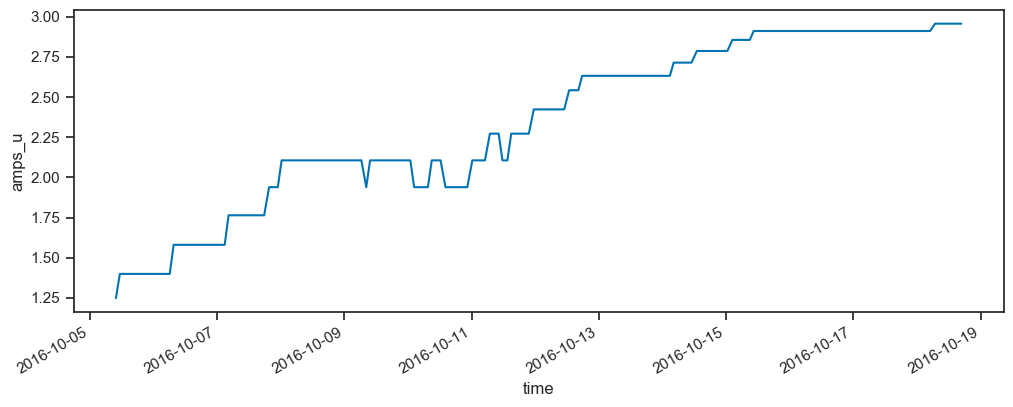

In [1776]:
((raw.amps_u.isel(mode=slice(0,4)).sum('mode')).pipe(np.abs)/(raw.amps_u.isel(mode=slice(5,20)).sum('mode')).pipe(np.abs)).plot()